Nb features AVANT sélection : 40
Distribution des classes (train complet) :
target_is_fraud
0    155076
1      4924
Name: count, dtype: int64
  → Ratio fraude : 3.08%

Taille X_train : (128000, 40)  |  X_val : (32000, 40)
Fraudes dans y_train : 3939 (3.08%)
Fraudes dans y_val   : 985 (3.08%)

Calcul de l'importance des features...
Top 20 features les plus importantes :
                feature  importance
              ip_risk_z    0.116953
         device_trust_z    0.066047
        num_devices_30d    0.065755
tx_amount_total_30d_eur    0.054178
      credit_score_norm    0.047704
     avg_amount_30d_eur    0.047415
           credit_score    0.043044
          tenure_months    0.037487
income_estimate_alt_eur    0.034580
             income_log    0.033735
     max_amount_30d_eur    0.032963
      annual_income_eur    0.030118
      internal_signal_7    0.029255
      internal_signal_8    0.028373
      internal_signal_5    0.028173
      internal_signal_2    0.028124
      internal_s

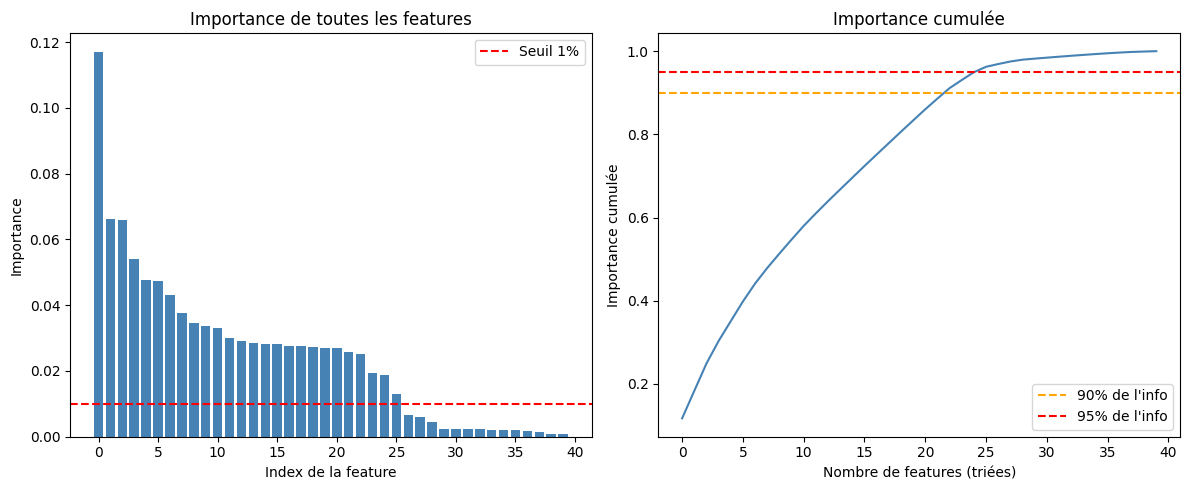


[Graphique sauvegardé → feature_importance_smote.png]

Nb features APRÈS sélection : 26

APRÈS SMOTE :
  Taille X_train : (161279, 26)  (était (128000, 26))
  Distribution :
target_is_fraud
0    124061
1     37218
Name: count, dtype: int64
  → Ratio fraude : 23.08%

Best params: {'max_depth': 10, 'n_estimators': 300}

Confusion Matrix :
[[30984    31]
 [  973    12]]

Classification Report :
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     31015
           1       0.28      0.01      0.02       985

    accuracy                           0.97     32000
   macro avg       0.62      0.51      0.50     32000
weighted avg       0.95      0.97      0.95     32000


[Classement des features sauvegardé → feature_importance_ranking_smote.csv]


In [13]:
"""
====================================================================
SÉLECTION DE FEATURES + SMOTE (Synthetic Minority Over-sampling)
====================================================================
Objectif : Même pipeline que feature_selection.py, mais on remplace
           class_weight='balanced' par SMOTE pour gérer le déséquilibre
           fraude/non-fraude.

Pourquoi SMOTE plutôt que class_weight ?
  - class_weight='balanced' : pénalise plus les erreurs sur la minorité
    → simple mais ne crée pas de nouvelles données
  - SMOTE : génère des exemples synthétiques de la classe minoritaire
    → le modèle "voit" plus d'exemples de fraude, apprend mieux les
      frontières de décision

RÈGLE CRITIQUE : SMOTE ne s'applique QUE sur X_train / y_train.
  Jamais sur la validation ni le test → sinon fuite de données (data leak)

Pipeline :
  1. Split train / val AVANT tout rééchantillonnage
  2. Calcul de l'importance des features (RF sur données originales)
  3. Sélection des features
  4. Application de SMOTE uniquement sur X_train
  5. GridSearchCV + évaluation sur X_val (données réelles, non augmentées)
====================================================================
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline 


# ──────────────────────────────────────────────────────────────────
# 0. CHARGEMENT DES DONNÉES
# ──────────────────────────────────────────────────────────────────

train = pd.read_csv('../6.Data/Yann_Process_train.csv')
test  = pd.read_csv('../6.Data/Yann_Process_test.csv')

target = 'target_is_fraud'
id_col = 'customer_id'

X = train.drop(columns=[target, id_col])
y = train[target]
X_test = test.drop(columns=[id_col])

print(f"Nb features AVANT sélection : {X.shape[1]}")
print(f"Distribution des classes (train complet) :\n{y.value_counts()}")
print(f"  → Ratio fraude : {y.mean()*100:.2f}%\n")


# ──────────────────────────────────────────────────────────────────
# 1. SPLIT TRAIN / VALIDATION
#    À faire EN PREMIER, avant SMOTE et avant la sélection de features,
#    pour s'assurer qu'aucune information du val ne "contamine" le train.
# ──────────────────────────────────────────────────────────────────

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y      # préserve le ratio fraude/non-fraude dans chaque split
)

print(f"Taille X_train : {X_train.shape}  |  X_val : {X_val.shape}")
print(f"Fraudes dans y_train : {y_train.sum()} ({y_train.mean()*100:.2f}%)")
print(f"Fraudes dans y_val   : {y_val.sum()} ({y_val.mean()*100:.2f}%)\n")


# ──────────────────────────────────────────────────────────────────
# 2. CALCUL DE L'IMPORTANCE DES FEATURES
#    On utilise X_train ORIGINAL (sans SMOTE) pour scorer les features.
#    Raison : SMOTE crée des points interpolés → les importances seraient
#    biaisées vers des zones synthétiques, pas les vraies données.
# ──────────────────────────────────────────────────────────────────

print("Calcul de l'importance des features...")

selector_rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    class_weight='balanced',   # ← équilibrage léger pour ce RF de sélection seulement
    random_state=42,
    n_jobs=-1
)
selector_rf.fit(X_train, y_train)

importance_df = pd.DataFrame({
    'feature':    X_train.columns,
    'importance': selector_rf.feature_importances_
}).sort_values('importance', ascending=False).reset_index(drop=True)

print("Top 20 features les plus importantes :")
print(importance_df.head(20).to_string(index=False))


# ──────────────────────────────────────────────────────────────────
# 3. VISUALISATION DES IMPORTANCES
# ──────────────────────────────────────────────────────────────────

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.bar(range(len(importance_df)), importance_df['importance'], color='steelblue')
plt.axhline(y=0.01, color='red', linestyle='--', label='Seuil 1%')
plt.xlabel('Index de la feature')
plt.ylabel('Importance')
plt.title('Importance de toutes les features')
plt.legend()

plt.subplot(1, 2, 2)
cumulative = importance_df['importance'].cumsum()
plt.plot(range(len(importance_df)), cumulative, color='steelblue')
plt.axhline(y=0.90, color='orange', linestyle='--', label="90% de l'info")
plt.axhline(y=0.95, color='red',    linestyle='--', label="95% de l'info")
plt.xlabel('Nombre de features (triées)')
plt.ylabel('Importance cumulée')
plt.title('Importance cumulée')
plt.legend()

plt.tight_layout()
plt.savefig('../6.Data/feature_importance_smote.png', dpi=150)
plt.show()
print("\n[Graphique sauvegardé → feature_importance_smote.png]")


# ──────────────────────────────────────────────────────────────────
# 4. SÉLECTION DES FEATURES
#
#    MÉTHODE : par seuil d'importance (décommente l'une ou l'autre)
# ──────────────────────────────────────────────────────────────────

# -- MÉTHODE --
SEUIL = 0.01
selected_features = importance_df[importance_df['importance'] >= SEUIL]['feature'].tolist()


print(f"\nNb features APRÈS sélection : {len(selected_features)}")

# Filtrer les datasets sur les features retenues
X_train_sel = X_train[selected_features]
X_val_sel   = X_val[selected_features]
X_test_sel  = X_test[selected_features]


# ──────────────────────────────────────────────────────────────────
# 5. APPLICATION DE SMOTE SUR X_TRAIN UNIQUEMENT
#    SMOTE interpole de nouveaux exemples entre les points minoritaires
#    existants (les fraudes) pour équilibrer les classes.
#
#    k_neighbors : nb de voisins utilisés pour l'interpolation
#      → valeur par défaut = 5, suffisant dans la plupart des cas
#      → si trop peu d'exemples de fraude, réduire à 3 ou 2
#
#    sampling_strategy : ratio cible après rééchantillonnage
#      → 'auto' = équilibre parfait 50/50
#      → 0.5    = la minorité atteint 50% de la majorité (moins agressif)
# ──────────────────────────────────────────────────────────────────

smote = SMOTE(
    sampling_strategy=0.3,  # ← 'auto' = 50/50 | essaie 0.3 ou 0.5 si trop agressif
    k_neighbors=5,
    random_state=42
)

X_train_resampled, y_train_resampled = smote.fit_resample(X_train_sel, y_train)

print(f"\nAPRÈS SMOTE :")
print(f"  Taille X_train : {X_train_resampled.shape}  (était {X_train_sel.shape})")
print(f"  Distribution :\n{pd.Series(y_train_resampled).value_counts()}")
print(f"  → Ratio fraude : {pd.Series(y_train_resampled).mean()*100:.2f}%\n")


# ──────────────────────────────────────────────────────────────────
# 6. GRID SEARCH SUR LES DONNÉES AUGMENTÉES PAR SMOTE
#    Note : on utilise un RandomForestClassifier SANS class_weight ici,
#    car SMOTE a déjà équilibré les classes manuellement.
# ──────────────────────────────────────────────────────────────────

rf = RandomForestClassifier(
    random_state=42
    # PAS de class_weight='balanced' → SMOTE s'en est chargé
)

param_grid = {
    'n_estimators': [100, 300],
    'max_depth':    [1, 10]
}

# StratifiedKFold pour préserver le ratio dans chaque fold du CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(rf, param_grid, cv=cv, scoring='f1', n_jobs=-1)
grid.fit(X_train_resampled, y_train_resampled)

best_model = grid.best_estimator_
print('Best params:', grid.best_params_)


# ──────────────────────────────────────────────────────────────────
# 7. ÉVALUATION SUR X_VAL (données RÉELLES, non augmentées)
#    C'est ici que l'on mesure la vraie performance sur des cas réels.
# ──────────────────────────────────────────────────────────────────

y_pred = best_model.predict(X_val_sel)

print('\nConfusion Matrix :')
print(confusion_matrix(y_val, y_pred))

print('\nClassification Report :')
print(classification_report(y_val, y_pred))


# ──────────────────────────────────────────────────────────────────
# 8. EXPORT
# ──────────────────────────────────────────────────────────────────

importance_df.to_csv('../6.Data/feature_importance_ranking_smote.csv', index=False)
print("\n[Classement des features sauvegardé → feature_importance_ranking_smote.csv]")

In [11]:
# Prédiction binaire 0/1 pour Kaggle
X_test_sel  = X_test[selected_features]

test_predictions = best_model.predict(X_test_sel)

submission = pd.DataFrame({
    "customer_id": test["customer_id"],
    "target_is_fraud": test_predictions
})

submission.to_csv('../7.Submission/submission_rf_simple.csv', index=False)
print('Submission exportée.')


Submission exportée.
